# The process used in the Bag of Words methodology used for the Ideal Scneario

In [0]:
%matplotlib inline
import re
import enum
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import json
from pprint import pprint
import csv
from ast import literal_eval


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/ham_2019spam_cleaned_df')

df.head()

,type,header,body
0,ham,Message-ID: <6759261.1075844047890.JavaMail.ev...,el paso south mainline shutin extended u trans...
1,spam,Return-Path: <SRS0=DrM4gn=XY=velavi.monster=ho...,listener title head advertisement span p div d...
2,ham,Message-ID: <23320673.1075852210910.JavaMail.e...,thank placing order footlockercom foot locker ...
3,spam,Return-Path: <SRS0=gVZRij=UE=goldrushsimple.ag...,html p
4,spam,Return-Path: <SRS0=GD8Svj=VG=focalify.wtf=dura...,alert tool banned amazon title head urgent new...


## The classes

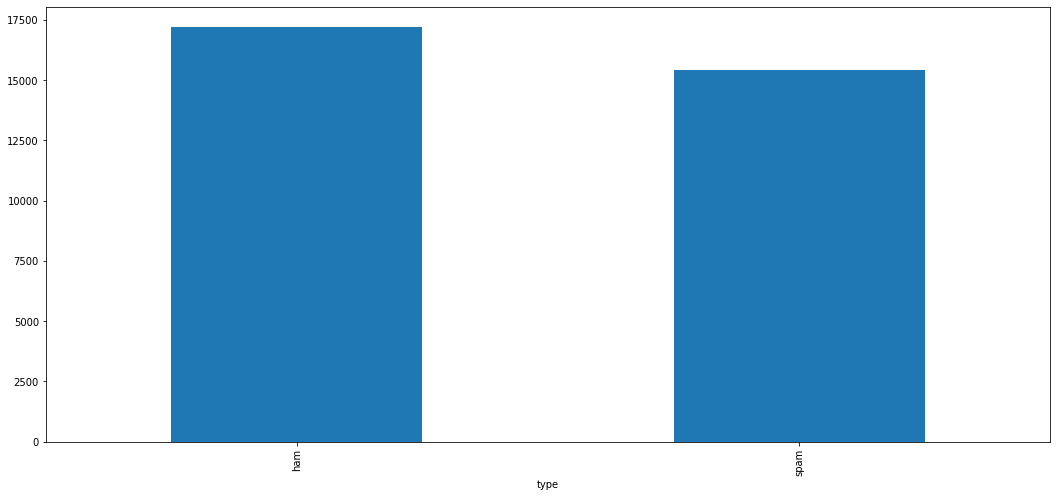

In [0]:
a = pd.Series([item for item in df.type])
df_a = a.value_counts().sort_index().rename_axis('type').reset_index(name='f')
df_a = df_a.set_index('type')

plt.subplots(figsize=(18,8))
df_a['f'].plot.bar()

In [0]:
df_a.head()
# df.info()

,f
type,
ham,17187
spam,15428


In [0]:
## Split into train/using 80/20

In [0]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
df = train
df_test = test

## Represent the cateogories using a number

In [5]:
from io import StringIO

# Train set
df = df[pd.notnull(df['body'])]
df['category_id'] = df['type'].factorize()[0]
category_id_df = df[['type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'type']].values)
df.head()

# Test set
df_test = df_test[pd.notnull(df_test['body'])]
df_test['category_id'] = df_test['type'].factorize()[0]
category_id_df = df_test[['type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'type']].values)

df_test.head()

,type,header,body,category_id
0,ham,Message-ID: <6759261.1075844047890.JavaMail.ev...,el paso south mainline shutin extended u trans...,0
6,spam,Return-Path: <SRS0=vQdNUx=UZ=http-b3s.ooo=elli...,amazing deal title head p td tr td tr longer w...,1
11,spam,Return-Path: <SRS0=X86bJz=VM=health-cpa.com=mo...,,1
18,ham,Message-ID: <12254969.1075856639867.JavaMail.e...,beth would appreciate see 1145 tomorrow vince ...,0
20,ham,Message-ID: <9754400.1075863707450.JavaMail.ev...,vince next time program offered ca october see...,0


In [6]:
print(category_to_id)

{'ham': 0, 'spam': 1}


## Feature Extraction

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn import metrics

X_train = df['body']
X_test = df_test['body']
y_train = df['type']
y_test = df_test['type']


vectorizer = CountVectorizer() #BoW count
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Benchmarking results of 4 different ML models
- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.model_selection import cross_val_score

# use pipeline

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(random_state=0),
]


for model in models:
  model_name = model.__class__.__name__
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  print(model_name)
  print(metrics.classification_report(y_test,y_pred))

RandomForestClassifier
              precision    recall  f1-score   support

         ham       0.65      1.00      0.78      3443
        spam       1.00      0.38      0.55      3058

    accuracy                           0.71      6501
   macro avg       0.82      0.69      0.67      6501
weighted avg       0.81      0.71      0.68      6501



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      3443
        spam       0.98      0.99      0.99      3058

    accuracy                           0.99      6501
   macro avg       0.99      0.99      0.99      6501
weighted avg       0.99      0.99      0.99      6501

MultinomialNB
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      3443
        spam       1.00      0.94      0.97      3058

    accuracy                           0.97      6501
   macro avg       0.97      0.97      0.97      6501
weighted avg       0.97      0.97      0.97      6501

BernoulliNB
              precision    recall  f1-score   support

         ham       0.68      1.00      0.81      3443
        spam       1.00      0.47      0.64      3058

    accuracy                           0.75      6501
   macro avg       0.84      0.73      0.72      6501
weighted avg       0.83      0.75     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3443
        spam       1.00      1.00      1.00      3058

    accuracy                           1.00      6501
   macro avg       1.00      1.00      1.00      6501
weighted avg       1.00      1.00      1.00      6501



The best model seems to be LogisticRegression

Lets test it:

In [0]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(lr.predict(vectorizer.transform(["hi how are you office"])))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


['ham']


In [0]:
print(lr.predict(vectorizer.transform(["Buy Viagra instant cheap easy"])))

['spam']


## Save model

In [0]:
import pickle 
# Save the trained model as a pickle string. 
with open('/content/drive/My Drive/Colab Notebooks/ideal_bow_model.pickle', 'wb') as handle:
    pickle.dump(lr, handle)

# Load the pickled model 
with open('/content/drive/My Drive/Colab Notebooks/ideal_bow_model.pickle', 'rb') as saved_model:
    lr_from_pickle = pickle.load(saved_model)
  


#### Use the loaded pickled model to make predictions 

In [19]:
lr_from_pickle.predict(vectorizer.transform(["Buy Viagra instant cheap easy"])) 

array(['spam'], dtype=object)